<a href="https://colab.research.google.com/github/codyub/ESAA/blob/main/%EB%B2%A0%EC%9D%B4%EC%8A%A4%EB%9D%BC%EC%9D%B8_%EC%BD%94%EB%93%9C_%EC%88%98%EC%A0%95(%EC%B6%94%EA%B0%80%EB%B3%80%EC%88%98_%EC%B5%9C%EC%A2%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 및 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/ESAA/프로젝트3_영화관객수예측/영화관객수/")

Mounted at /content/drive


In [4]:
train = pd.read_csv('movies_train.csv',parse_dates=[3]) # 시간이 있어서, datetime으로 가져옴
test = pd.read_csv('movies_test.csv',parse_dates=[3])

## 데이터탐색

- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- 위 데이터는 대부분이 널 값을 갖고 있음 

- box_off_num: 실제 관객 수로, 우리가 test에서 예측해야 할 데이터

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           600 non-null    object        
 1   distributor     600 non-null    object        
 2   genre           600 non-null    object        
 3   release_time    600 non-null    datetime64[ns]
 4   time            600 non-null    int64         
 5   screening_rat   600 non-null    object        
 6   director        600 non-null    object        
 7   dir_prev_bfnum  270 non-null    float64       
 8   dir_prev_num    600 non-null    int64         
 9   num_staff       600 non-null    int64         
 10  num_actor       600 non-null    int64         
 11  box_off_num     600 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 56.4+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           243 non-null    object        
 1   distributor     243 non-null    object        
 2   genre           243 non-null    object        
 3   release_time    243 non-null    datetime64[ns]
 4   time            243 non-null    int64         
 5   screening_rat   243 non-null    object        
 6   director        243 non-null    object        
 7   dir_prev_bfnum  107 non-null    float64       
 8   dir_prev_num    243 non-null    int64         
 9   num_staff       243 non-null    int64         
 10  num_actor       243 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 21.0+ KB


# 각 데이터의 구성 알아보기

In [7]:
train.director.value_counts() # 감독이 472명이나 존재함. 아마 의미가 없을 것임. 

홍상수           7
장률            4
신재호           4
우민호           4
노진수           4
             ..
권오광           1
한윤선           1
박찬경           1
New Pistol    1
백운학           1
Name: director, Length: 472, dtype: int64

# 데이터 전처리

# 추가변수: 스크린데이터

# 제목의 공백을 제거하기

In [8]:
#영화관 스크린 데이터 불러오기 
df_screen = pd.read_excel('screen.xlsx')
df_screen.head()

,title,num_screen
0,트랜스포머 3,1409.0
1,최종병기 활,615.0
2,써니,472.0
3,완득이,500.0
4,쿵푸팬더 2,948.0


In [9]:
for i in range(len(df_screen)):
  df_screen['title'][i] = str(df_screen['title'][i]).replace(" ","")

df_screen

,title,num_screen
0,트랜스포머3,1409.0
1,최종병기활,615.0
2,써니,472.0
3,완득이,500.0
4,쿵푸팬더2,948.0
...,...,...
5266,아내그리고밀애2,1.0
5267,아내그리고밀애,1.0
5268,H2:어느살인마의가족이야기,1.0
5269,드리프트우드,1.0


In [10]:
train = pd.read_csv('movies_train.csv',parse_dates=[3]) # 시간이 있어서, datetime으로 가져옴
test = pd.read_csv('movies_test.csv',parse_dates=[3])

In [11]:
for i in range(len(train)):
  train['title'][i] = str(train['title'][i]).replace(" ","")

train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


In [12]:
for i in range(len(test)):
  test['title'][i] = str(test['title'][i]).replace(" ","")

test

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가여자를좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1
...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서소년에게,디씨드,드라마,2015-11-19,78,15세 관람가,안슬기,2.590000e+03,1,4,4
239,울보권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2
240,어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4
241,말하지못한비밀,(주)씨타마운틴픽쳐스,드라마,2015-10-22,102,청소년 관람불가,송동윤,5.069900e+04,1,68,7


# 스크린 수 반영하기

In [13]:
train['num_screen'] = 0
train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,num_screen
0,개들의전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,0
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,0
2,은밀하게위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,0
3,나는공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,0
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091,0
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438,0
597,살인의강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475,0
598,악의연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525,0


In [14]:
for i in range(len(train)):
  for j in range(len(df_screen)):
    if train['title'][i] == df_screen['title'][j]:
        a = df_screen['num_screen'][j]
        train['num_screen'][i] = a

In [15]:
train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,num_screen
0,개들의전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,94.0
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,1075.0
2,은밀하게위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,1341.0
3,나는공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,278.0
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091,0.0
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438,552.0
597,살인의강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475,14.0
598,악의연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525,776.0


In [16]:
for i in range(len(train)):
  if train['num_screen'][i] == 0:
    print(train['title'][i], i)

# 아래 데이터는 부재, 한자 등으로 인해 데이터가 있음에도 반영되지 못함

해로 12
원오브어카인드3D 75
심야의FM 81
고사두번째이야기:교생실습 183
안녕?오케스트라 271
식객:김치전쟁 489
모차르트락오페라 508
귀 528
해무 595


In [17]:
train['num_screen'][12] = 24
train['num_screen'][75] = 39
train['num_screen'][81] = 422
train['num_screen'][183] = 320
train['num_screen'][271] = 49
train['num_screen'][489] = 357
train['num_screen'][508] = 0 # 정보 없음
train['num_screen'][528] = 30
train['num_screen'][595] = 584

In [18]:
for i in range(len(train)):
  if train['num_screen'][i] == 0:
    print(train['title'][i], i)

모차르트락오페라 508


In [19]:
test['num_screen'] = 0
test

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,num_screen
0,용서는없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,0
1,아빠가여자를좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3,0
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7,0
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2,0
4,평행이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서소년에게,디씨드,드라마,2015-11-19,78,15세 관람가,안슬기,2.590000e+03,1,4,4,0
239,울보권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2,0
240,어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4,0
241,말하지못한비밀,(주)씨타마운틴픽쳐스,드라마,2015-10-22,102,청소년 관람불가,송동윤,5.069900e+04,1,68,7,0


In [20]:
for i in range(len(test)):
  for j in range(len(df_screen)):
    if test['title'][i] == df_screen['title'][j]:
        a = df_screen['num_screen'][j]
        test['num_screen'][i] = a

In [21]:
for i in range(len(test)):
  if test['num_screen'][i] == 0:
    print(test['title'][i], i)

# 아래 데이터는 부재, 한자 등으로 인해 데이터가 있음에도 반영되지 못함

아마존의눈물극장판 8
가문의귀환 71


In [22]:
test['num_screen'][8] = 47
test['num_screen'][71] = 447

# 데이터 확인 

In [23]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,num_screen
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452,0.604988
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184,0.316594
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674,0.469383
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265,0.783867
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179,0.094495
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000,0.740189
num_screen,0.604988,0.316594,0.469383,0.783867,0.094495,0.740189,1.000000


In [24]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
num_screen          0
dtype: int64

# 의미없는 데이터 제거

In [25]:
# 제목 : 의미가 없기 때문에 제거
train = train.drop(['title'],axis= 1)
test = test.drop(['title'],axis= 1)

In [26]:
# 감독명 : 너무 다양해서 제거
train = train.drop(['director'],axis = 1)
test = test.drop(['director'],axis = 1)

# 시간이 date가 아니라 object로 되어 있어 바꿔줘야 함

> 데이터 다시 로드했음: parse_dates=[3]
> 년/월 변수를 숫자만 떼어서 넣는게 나을까 아니면, datetime 데이터로 바꾸는게 나을까?



In [27]:
 # 개봉일을 바탕으로 년/월 변수 생성
# train['년'] = train.release_time.dt.year 
train['month'] = train.release_time.dt.month

# test['년'] = test.release_time.dt.year 
test['month'] = test.release_time.dt.month

In [28]:
train.info() # 어차피 년, 월만 떼어버리면, 숫자로 들어가므로 굳이 시간으로 가져올 필요가 없었을 수 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   distributor     600 non-null    object        
 1   genre           600 non-null    object        
 2   release_time    600 non-null    datetime64[ns]
 3   time            600 non-null    int64         
 4   screening_rat   600 non-null    object        
 5   dir_prev_bfnum  270 non-null    float64       
 6   dir_prev_num    600 non-null    int64         
 7   num_staff       600 non-null    int64         
 8   num_actor       600 non-null    int64         
 9   box_off_num     600 non-null    int64         
 10  num_screen      600 non-null    float64       
 11  month           600 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 56.4+ KB


# 배급사 전처리

In [29]:
import re

In [30]:
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [31]:
# 배급사 쓸모 없는 글자 제거
train['distributor'] = train.distributor.str.replace("(주)",'')
test['distributor'] = test.distributor.str.replace("(주)", '')

In [32]:
def name_distributor(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [33]:
train['distributor'] = train.distributor.apply(name_distributor)
test['distributor'] = test.distributor.apply(name_distributor)

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   distributor     600 non-null    object        
 1   genre           600 non-null    object        
 2   release_time    600 non-null    datetime64[ns]
 3   time            600 non-null    int64         
 4   screening_rat   600 non-null    object        
 5   dir_prev_bfnum  270 non-null    float64       
 6   dir_prev_num    600 non-null    int64         
 7   num_staff       600 non-null    int64         
 8   num_actor       600 non-null    int64         
 9   box_off_num     600 non-null    int64         
 10  num_screen      600 non-null    float64       
 11  month           600 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 56.4+ KB


In [35]:
train.isna().sum()

distributor         0
genre               0
release_time        0
time                0
screening_rat       0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
num_screen          0
month               0
dtype: int64

In [36]:
train.distributor.value_counts()

CJ          68
롯데엔터테인먼트    52
NEW         38
마운틴픽처스      33
쇼박스         28
            ..
OAL올         1
위더스필름        1
콘텐츠윙         1
팝파트너스        1
퍼스트런         1
Name: distributor, Length: 147, dtype: int64

# 장르별 영화 관객수 평균값으로 랭크 인코딩

In [37]:
train.groupby('genre').box_off_num.mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [38]:
train['genre_rank'] = train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
test['genre_rank'] = test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

# 배급사별 영화 관객수 중위값 기준으로 배급사 랭크 인코딩

In [39]:
tr_nm_rank = train.groupby('distributor').box_off_num.median().reset_index(name = 'num_rank').sort_values(by = 'num_rank')
tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,2.0
15,고구마공작소,8.0
52,사람과사람들,42.0
97,위드시네마,46.0
19,나우콘텐츠,54.0
...,...,...
113,전망좋은영화사,1214237.0
105,이십세기폭스코리아,1422844.0
56,쇼박스,2138560.0
84,영구아트무비,2541603.0


In [40]:
tr_nm_rank['num_rank'] = [i + 1 for i in range(tr_nm_rank.shape[0])]

In [41]:
tr_nm_rank # 랭크가 아래로 갈수록 관객수가 많음

,distributor,num_rank
110,인피니티엔터테인먼트,1
15,고구마공작소,2
52,사람과사람들,3
97,위드시네마,4
19,나우콘텐츠,5
...,...,...
113,전망좋은영화사,143
105,이십세기폭스코리아,144
56,쇼박스,145
84,영구아트무비,146


# 계절변수 추가

In [42]:
# 랭킹을 줄 지, 더미화 시키는 것이 나을지 모르겠음 -> 랭킹이 나음

In [43]:
def func(month):
  if month in [3, 4, 5]:
    return '봄'
  elif month in [6, 7, 8]:
    return '여름'
  elif month in [9, 10, 11]:
    return '가을'
  elif month in [12, 1, 2]:
    return '겨울'

In [44]:
train['season'] = train['month'].apply(lambda x: func(x))
test['season'] = test['month'].apply(lambda x: func(x))

In [45]:
train.head()

,distributor,genre,release_time,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,num_screen,month,genre_rank,season
0,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,NaN,0,91,2,23398,94.0,11,11,가을
1,쇼박스,느와르,2015-11-19,130,청소년 관람불가,1161602.50,2,387,3,7072501,1075.0,11,12,가을
2,쇼박스,액션,2013-06-05,123,15세 관람가,220775.25,4,343,4,6959083,1341.0,6,11,여름
3,NEW,코미디,2012-07-12,101,전체 관람가,23894.00,2,20,6,217866,278.0,7,9,여름
4,쇼박스,코미디,2010-11-04,108,15세 관람가,1.00,1,251,2,483387,345.0,11,9,가을


In [46]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,num_screen,month,genre_rank
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452,0.604988,-0.023969,0.404035
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184,0.316594,0.064117,0.129922
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674,0.469383,0.034019,0.236391
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265,0.783867,-0.002841,0.466936
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179,0.094495,-0.015063,0.058944
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000,0.740189,0.019104,0.279454
num_screen,0.604988,0.316594,0.469383,0.783867,0.094495,0.740189,1.000000,0.031558,0.398784
month,-0.023969,0.064117,0.034019,-0.002841,-0.015063,0.019104,0.031558,1.000000,-0.022913
genre_rank,0.404035,0.129922,0.236391,0.466936,0.058944,0.279454,0.398784,-0.022913,1.000000


# 데이터 이어 붙이기

In [47]:
train = pd.merge(train, tr_nm_rank, how = 'left')

In [48]:
test = pd.merge(test, tr_nm_rank, how = 'left')

In [49]:
# release time은 변수 처리가 끝났으므로 제거
train =  train.drop(['release_time'],axis = 1)
test =  test.drop(['release_time'],axis = 1)

In [50]:
train # screening_rat, season은 더미화가 필요

,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,num_screen,month,genre_rank,season,num_rank
0,롯데엔터테인먼트,액션,96,청소년 관람불가,NaN,0,91,2,23398,94.0,11,11,가을,134
1,쇼박스,느와르,130,청소년 관람불가,1161602.50,2,387,3,7072501,1075.0,11,12,가을,145
2,쇼박스,액션,123,15세 관람가,220775.25,4,343,4,6959083,1341.0,6,11,여름,145
3,NEW,코미디,101,전체 관람가,23894.00,2,20,6,217866,278.0,7,9,여름,140
4,쇼박스,코미디,108,15세 관람가,1.00,1,251,2,483387,345.0,11,9,가을,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,NEW,드라마,111,청소년 관람불가,3833.00,1,510,7,1475091,584.0,8,8,여름,140
596,쇼박스,드라마,127,15세 관람가,496061.00,1,286,6,1716438,552.0,3,8,봄,145
597,마운틴픽처스,공포,99,청소년 관람불가,NaN,0,123,4,2475,14.0,9,7,가을,46
598,CJ,느와르,102,15세 관람가,NaN,0,431,4,2192525,776.0,5,12,봄,141


# 시각화

- 상관계수

In [51]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,num_screen,month,genre_rank,num_rank
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452,0.604988,-0.023969,0.404035,0.525554
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184,0.316594,0.064117,0.129922,0.178457
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674,0.469383,0.034019,0.236391,0.361585
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265,0.783867,-0.002841,0.466936,0.653489
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179,0.094495,-0.015063,0.058944,0.080893
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000,0.740189,0.019104,0.279454,0.407956
num_screen,0.604988,0.316594,0.469383,0.783867,0.094495,0.740189,1.000000,0.031558,0.398784,0.693622
month,-0.023969,0.064117,0.034019,-0.002841,-0.015063,0.019104,0.031558,1.000000,-0.022913,-0.061528
genre_rank,0.404035,0.129922,0.236391,0.466936,0.058944,0.279454,0.398784,-0.022913,1.000000,0.292513
num_rank,0.525554,0.178457,0.361585,0.653489,0.080893,0.407956,0.693622,-0.061528,0.292513,1.000000


- 히스토그램

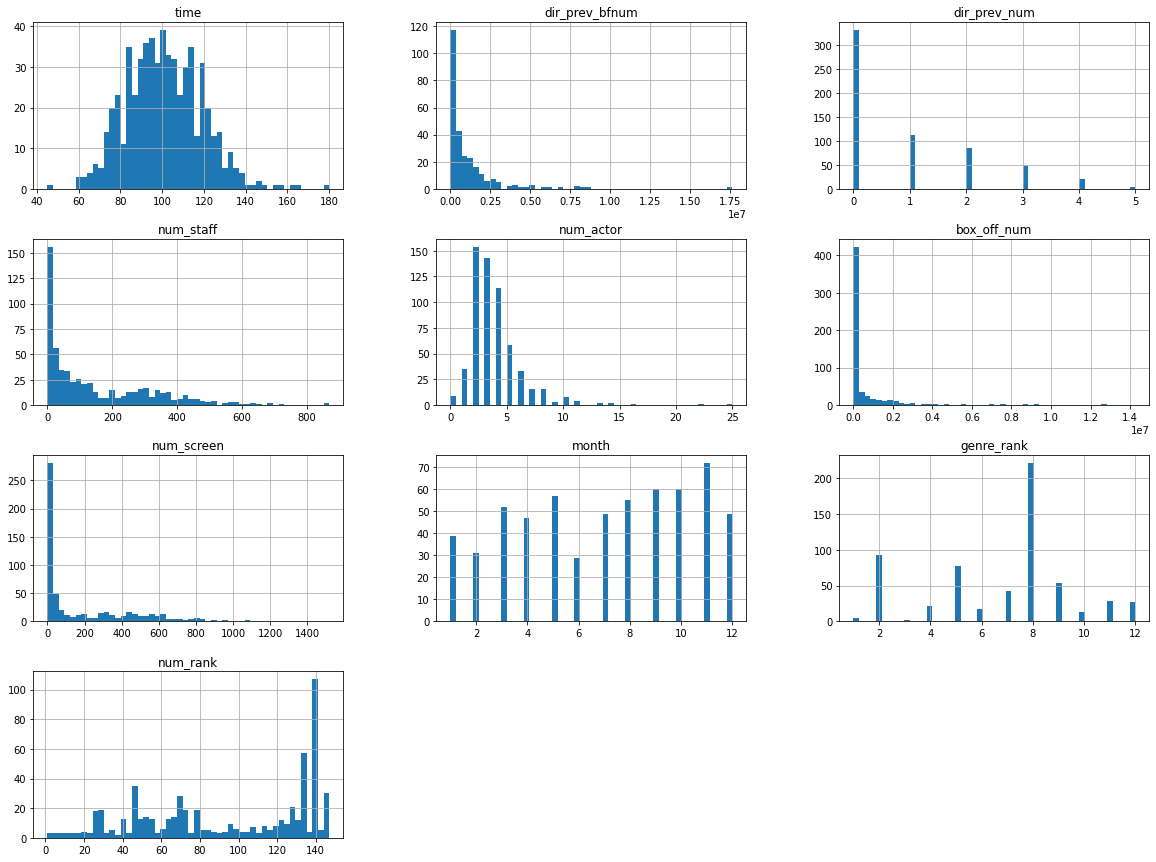

In [52]:
# 히스토그램 한 번에 그리기
train.hist(bins = 50, figsize = (20,15))
plt.show() # 배우, 스태프 수는 왜도가 심함, 이상치 제거도 필요할 것으로 예상됨

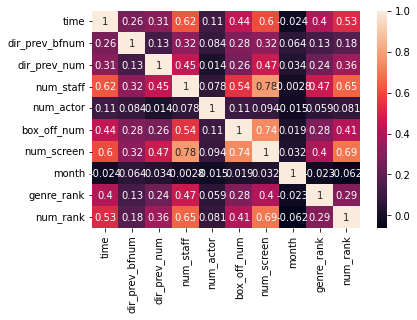

In [53]:
sns.heatmap(train.corr(), annot = True) # 스태프 수, 시간이 상대적으로 높은 영향을 주고 있음을 알 수 있다. # 시간이 아닌 object는 여기서 나오지 않음.

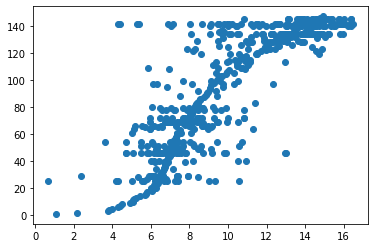

In [54]:
plt.scatter(np.log1p(train['box_off_num']),train['num_rank']) # 배급사에 따른 랭킹
plt.show()

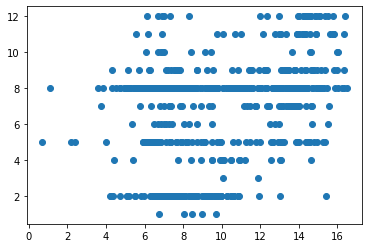

In [55]:
plt.scatter(np.log1p(train['box_off_num']),train['genre_rank'])
plt.show()

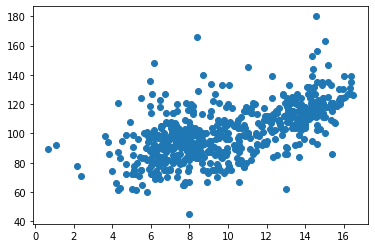

In [56]:
plt.scatter(np.log1p(train['box_off_num']),train['time'])
plt.show() # 시간이 너무 길면 관객수가 떨어짐. 적정 시간이 존재함. 

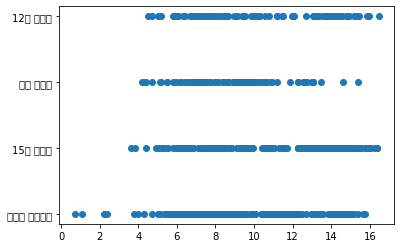

In [57]:
plt.scatter(np.log1p(train['box_off_num']),train['screening_rat'])
plt.show() # 연령에 따른 문제는 딱히 보이지 않음. 상대적으로 전체 관람 영화/청소년 관람 불가 영화의 관객 수가 떨어지는 경향이 있음.

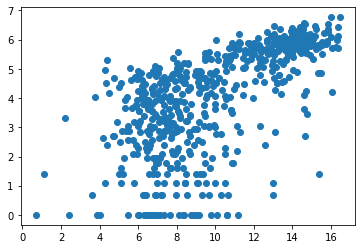

In [58]:
plt.scatter(np.log1p(train['box_off_num']),np.log1p(train['num_staff']))
plt.show()# 스태프 수가 많으면 관객수가 많은 편, 로그화 한다고 더 좋은 그래프가 되는 것 같지는 않음. 

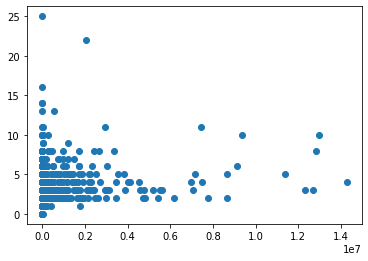

In [59]:
plt.scatter(train['box_off_num'],train['num_actor'])
plt.show() # 배우 수가 일정 이상 많을 필요는 없는 것으로 추정

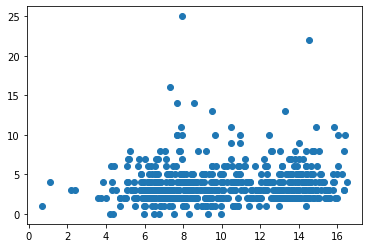

In [60]:
plt.scatter(np.log1p(train.box_off_num),train['num_actor'])
plt.show() # 별로 상관 없어보임. 로그화 시켰을 때  좀 더 데이터 분포가 안정적인 것으로 추정

# 테스트 전처리

In [61]:
test # 테스트에는 새로운 배급사가 존재함. 

,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,num_screen,month,genre_rank,season,num_rank
0,시네마서비스,느와르,125,청소년 관람불가,3.005290e+05,2,304,3,334,1,12,겨울,132.0
1,쇼박스,멜로/로맨스,113,12세 관람가,3.427002e+05,4,275,3,283,1,5,겨울,145.0
2,CJ,드라마,115,12세 관람가,4.206611e+06,3,419,7,405,1,8,겨울,141.0
3,쇼박스,액션,116,15세 관람가,6.913420e+05,2,408,2,572,2,11,겨울,145.0
4,CJ,공포,110,15세 관람가,3.173800e+04,1,380,1,272,2,7,겨울,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,디씨드,드라마,78,15세 관람가,2.590000e+03,1,4,4,21,11,8,가을,112.0
239,인디스토리,다큐멘터리,86,12세 관람가,NaN,0,18,2,13,10,2,가을,69.0
240,컨텐츠온미디어,느와르,107,청소년 관람불가,NaN,0,224,4,179,10,12,가을,NaN
241,마운틴픽처스,드라마,102,청소년 관람불가,5.069900e+04,1,68,7,3,10,8,가을,46.0


In [62]:
test.isna().sum() # 관객 수 랭킹에 뭘 부여할 것인가?

distributor         0
genre               0
time                0
screening_rat       0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
num_screen          0
month               0
genre_rank          0
season              0
num_rank           31
dtype: int64

In [63]:
test.fillna(0, inplace = True)
train.fillna(0, inplace = True)

In [64]:
test.isna().sum() 

distributor       0
genre             0
time              0
screening_rat     0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
num_screen        0
month             0
genre_rank        0
season            0
num_rank          0
dtype: int64

# 차원 축소

In [65]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,num_screen,month,genre_rank,num_rank
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452,0.604988,-0.023969,0.404035,0.525554
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791,0.379450,0.047183,0.174314,0.240184
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674,0.469383,0.034019,0.236391,0.361585
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265,0.783867,-0.002841,0.466936,0.653489
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179,0.094495,-0.015063,0.058944,0.080893
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000,0.740189,0.019104,0.279454,0.407956
num_screen,0.604988,0.379450,0.469383,0.783867,0.094495,0.740189,1.000000,0.031558,0.398784,0.693622
month,-0.023969,0.047183,0.034019,-0.002841,-0.015063,0.019104,0.031558,1.000000,-0.022913,-0.061528
genre_rank,0.404035,0.174314,0.236391,0.466936,0.058944,0.279454,0.398784,-0.022913,1.000000,0.292513
num_rank,0.525554,0.240184,0.361585,0.653489,0.080893,0.407956,0.693622,-0.061528,0.292513,1.000000


In [66]:
from sklearn.preprocessing import StandardScaler

# 속성 값을 standardscaler를 이용해 표준 정규 분포를 가지는 값들로 변환
train_scaled=StandardScaler().fit_transform(train.iloc[:, 4:6])

In [67]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# fit과 transform 호출해 PCA 변환 데이터 반환
pca.fit(train_scaled)
train_pca=pca.transform(train_scaled)
print(train_pca.shape)

(600, 2)


In [68]:
# PCA 변환된 데이터의 칼럼 명을 각각 pca_component_1, pca_component_2로 명명.
pca_columns=['pca_component_1', 'pca_component_2']
train_pca=pd.DataFrame(train_pca, columns=pca_columns)
train_pca['box_off_num']=train.box_off_num
train_pca.head(3)

,pca_component_1,pca_component_2,box_off_num
0,-0.779727,0.268793,23398
1,1.044084,-0.299458,7072501
2,1.731651,-2.003952,6959083


In [69]:
train_pca.corr()

,pca_component_1,pca_component_2,box_off_num
pca_component_1,1.000000e+00,-2.388088e-16,0.331159
pca_component_2,-2.388088e-16,1.000000e+00,0.031057
box_off_num,3.311589e-01,3.105692e-02,1.000000


In [70]:
train['pca_component_1'] = train_pca['pca_component_1']
train.head()

,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,num_screen,month,genre_rank,season,num_rank,pca_component_1
0,롯데엔터테인먼트,액션,96,청소년 관람불가,0.00,0,91,2,23398,94.0,11,11,가을,134,-0.779727
1,쇼박스,느와르,130,청소년 관람불가,1161602.50,2,387,3,7072501,1075.0,11,12,가을,145,1.044084
2,쇼박스,액션,123,15세 관람가,220775.25,4,343,4,6959083,1341.0,6,11,여름,145,1.731651
3,NEW,코미디,101,전체 관람가,23894.00,2,20,6,217866,278.0,7,9,여름,140,0.429217
4,쇼박스,코미디,108,15세 관람가,1.00,1,251,2,483387,345.0,11,9,가을,145,-0.181711


In [71]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,num_screen,month,genre_rank,num_rank,pca_component_1
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452,0.604988,-0.023969,0.404035,0.525554,0.342723
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791,0.379450,0.047183,0.174314,0.240184,0.835648
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674,0.469383,0.034019,0.236391,0.361585,0.835648
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265,0.783867,-0.002841,0.466936,0.653489,0.490854
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179,0.094495,-0.015063,0.058944,0.080893,0.033804
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000,0.740189,0.019104,0.279454,0.407956,0.331159
num_screen,0.604988,0.379450,0.469383,0.783867,0.094495,0.740189,1.000000,0.031558,0.398784,0.693622,0.507889
month,-0.023969,0.047183,0.034019,-0.002841,-0.015063,0.019104,0.031558,1.000000,-0.022913,-0.061528,0.048586
genre_rank,0.404035,0.174314,0.236391,0.466936,0.058944,0.279454,0.398784,-0.022913,1.000000,0.292513,0.245740
num_rank,0.525554,0.240184,0.361585,0.653489,0.080893,0.407956,0.693622,-0.061528,0.292513,1.000000,0.360061


In [72]:
test_scaled=StandardScaler().fit_transform(test.iloc[:, 4:6])

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# fit과 transform 호출해 PCA 변환 데이터 반환
pca.fit(test_scaled)
test_pca=pca.transform(test_scaled)
print(test_pca.shape)

(243, 2)


In [73]:
# PCA 변환된 데이터의 칼럼 명을 각각 pca_component_1, pca_component_2로 명명.
pca_columns=['pca_component_1', 'pca_component_2']
test_pca=pd.DataFrame(test_pca, columns=pca_columns)
test_pca.head(3)

,pca_component_1,pca_component_2
0,0.606812,-0.748724
1,1.819929,-1.896861
2,4.206487,1.670324


In [74]:
test['pca_component_1'] = test_pca['pca_component_1']
test.head()

,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,num_screen,month,genre_rank,season,num_rank,pca_component_1
0,시네마서비스,느와르,125,청소년 관람불가,3.005290e+05,2,304,3,334,1,12,겨울,132.0,0.606812
1,쇼박스,멜로/로맨스,113,12세 관람가,3.427002e+05,4,275,3,283,1,5,겨울,145.0,1.819929
2,CJ,드라마,115,12세 관람가,4.206611e+06,3,419,7,405,1,8,겨울,141.0,4.206487
3,쇼박스,액션,116,15세 관람가,6.913420e+05,2,408,2,572,2,11,겨울,145.0,0.907906
4,CJ,공포,110,15세 관람가,3.173800e+04,1,380,1,272,2,7,겨울,141.0,-0.190587


# actor 제거 ver + dir_prev_bfnum	dir_prev_num를 주성분1개로 변경

In [75]:
X = train[['num_rank', 'time', 'num_staff', 'genre_rank', 'screening_rat','season', 'pca_component_1','num_screen']]
y = np.log1p(train.box_off_num) # 관객 수가 너무 많고 편차가 커서 로그화 시킴
X['num_screen'] = np.log1p(X['num_screen'])

In [76]:
X = pd.get_dummies(columns = ['screening_rat'], data = X)
X = pd.get_dummies(columns = ['season'], data = X)

In [77]:
target = test[['num_rank', 'time', 'num_staff', 'genre_rank', 'screening_rat','season', 'pca_component_1','num_screen']]
target = pd.get_dummies(columns = ['screening_rat'], data = target)
target = pd.get_dummies(columns = ['season'], data = target)
target['num_screen'] = np.log1p(target['num_screen'])

# 모델정의 및 학습

# 모델

In [78]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

10-fold 교차검증

In [79]:
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)

In [80]:
gbm = GradientBoostingRegressor(random_state = 42)

rmse_list = []
gb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in gbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in gbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    gb_pred += (sub_pred / 10)

np.mean(rmse_list)

1390358.6347216712

In [81]:
lgbm = LGBMRegressor(random_state = 518)

rmse_list = []
lgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    lgb_pred += (sub_pred / 10)

np.mean(rmse_list)

1413012.651817811

In [82]:
xgb = XGBRegressor(random_state = 518)

rmse_list = []
xgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    xgb_pred += (sub_pred / 10)

np.mean(rmse_list)

[10:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

1301794.540481512

In [83]:
rf = RandomForestRegressor(random_state = 518)

rmse_list = []
rf_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    rf.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    rf_pred += (sub_pred / 10)

np.mean(rmse_list)

1347619.930115092

# 학습 된 모델로 예측 데이터 생성

In [84]:
pred12 = (xgb_pred + lgb_pred + rf_pred + gb_pred) / 4

## 제출파일 생성

In [85]:
submission = pd.read_csv('submission.csv')
submission

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0
...,...,...
238,해에게서 소년에게,0
239,울보 권투부,0
240,어떤살인,0
241,말하지 못한 비밀,0


In [86]:
submission['box_off_num'] = pred12

In [87]:
submission

,title,box_off_num
0,용서는 없다,4.028828e+05
1,아빠가 여자를 좋아해,3.770464e+05
2,하모니,9.891015e+05
3,의형제,1.777696e+06
4,평행 이론,3.478984e+05
...,...,...
238,해에게서 소년에게,5.668199e+03
239,울보 권투부,3.128836e+03
240,어떤살인,2.756083e+04
241,말하지 못한 비밀,6.378597e+02


In [ ]:
submission.to_csv('추가변수_pca.csv',index = False)

# 하이퍼파라미터 튜닝

# actor 제거 ver + dir_prev_bfnum	dir_prev_num를 주성분1개로 변경

In [88]:
X = train[['num_rank', 'time', 'num_staff', 'genre_rank', 'screening_rat','season', 'pca_component_1','num_screen']]
y = np.log1p(train.box_off_num) # 관객 수가 너무 많고 편차가 커서 로그화 시킴
X['num_screen'] = np.log1p(X['num_screen'])

In [89]:
X = pd.get_dummies(columns = ['screening_rat'], data = X)
X = pd.get_dummies(columns = ['season'], data = X)

In [90]:
target = test[['num_rank', 'time', 'num_staff', 'genre_rank', 'screening_rat','season', 'pca_component_1','num_screen']]
target = pd.get_dummies(columns = ['screening_rat'], data = target)
target = pd.get_dummies(columns = ['season'], data = target)
target['num_screen'] = np.log1p(target['num_screen'])

# 모델정의 및 학습

# 모델

In [91]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# 모델_하이퍼파라미터튜닝

In [92]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [93]:
#xgboost 회귀 트리
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[2000,1000,600,500,400,300,100,50]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

[10:20:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [94]:
#ligthgbm 회귀 트리
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[2000,1000,600,500,400,300,100,50]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 1.0922, 최적 alpha:{'n_estimators': 500}


In [95]:
# rf
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

rf_params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }
rf_reg = RandomForestRegressor(n_estimators=100)

best_rf = print_best_params(rf_reg, rf_params)

RandomForestRegressor 5 CV 시 최적 평균 RMSE 값: 1.0587, 최적 alpha:{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}


In [96]:
# gb,

gbm_params = { 'n_estimators' : range(5,50,10),
           'max_features' : range(1,4),
           'max_depth' : range(3,5),
           'learning_rate' : np.linspace(0.1,1,10)
            }
gbm_reg = GradientBoostingRegressor(random_state = 42)

best_gbm = print_best_params(gbm_reg, gbm_params)

GradientBoostingRegressor 5 CV 시 최적 평균 RMSE 값: 1.132, 최적 alpha:{'learning_rate': 0.2, 'max_depth': 4, 'max_features': 3, 'n_estimators': 45}


In [97]:
def get_rmse_pred(preds):
  from sklearn.metrics import mean_squared_error
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y, pred_value)
    rmse = np.sqrt(mse)
    print('{0} models rmse: {1}'.format(key, rmse))

train_rmse

In [98]:
xgb_reg = XGBRegressor(n_estimators=300, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
rf_reg = RandomForestRegressor(max_depth=10, min_samples_leaf=8, min_samples_split=16, n_estimators=100)
gbm_reg = GradientBoostingRegressor(learning_rate=0.2, max_depth=4, max_features=3, n_estimators=45)

xgb_reg.fit(X, y)
lgbm_reg.fit(X, y)
rf_reg.fit(X, y)
gbm_reg.fit(X, y)

xgb_pred = xgb_reg.predict(X)
lgbm_pred = lgbm_reg.predict(X)
rf_pred = rf_reg.predict(X)
gbm_pred = gbm_reg.predict(X)

pred = 0.25 * xgb_pred + 0.25 * lgbm_pred + 0.25 *rf_pred +0.25 *gbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred,
         'RF': rf_pred,
         'GBM': gbm_pred}
        
get_rmse_pred(preds)

[10:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 models rmse: 0.6946830890581741
XGBM models rmse: 0.6226108385614325
LGBM models rmse: 0.8339417232785304
RF models rmse: 0.8435816889488833
GBM models rmse: 0.6086682478055598


# 학습 된 모델로 예측 데이터 생성

In [99]:
xgb_pred = xgb_reg.predict(target)
lgbm_pred = lgbm_reg.predict(target)
rf_pred = rf_reg.predict(target)
gbm_pred = gbm_reg.predict(target)

pred15 = 0.25 * xgb_pred + 0.25 * lgbm_pred + 0.25 *rf_pred +0.25 *gbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred,
         'RF': rf_pred,
         'GBM': gbm_pred}

# 제출파일 생성

In [100]:
submission = pd.read_csv('submission.csv')
submission

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0
...,...,...
238,해에게서 소년에게,0
239,울보 권투부,0
240,어떤살인,0
241,말하지 못한 비밀,0


In [101]:
submission['box_off_num'] = np.expm1(pred15)

In [102]:
submission

,title,box_off_num
0,용서는 없다,5.214365e+05
1,아빠가 여자를 좋아해,3.896052e+05
2,하모니,1.101281e+06
3,의형제,1.733070e+06
4,평행 이론,4.174791e+05
...,...,...
238,해에게서 소년에게,6.520026e+03
239,울보 권투부,3.529135e+03
240,어떤살인,8.785752e+03
241,말하지 못한 비밀,6.096264e+02


In [103]:
submission.to_csv('추가변수_pca_튜닝.csv',index = False)